# Análisis Exploratorio de Datos (EDA): 

## Objetivo
Este notebook contiene el análisis exploratorio completo del dataset, siguiendo una estructura organizada y metódica para entender los datos, limpiarlos y prepararlos para modelado.

## Contenido
1. Configuración Inicial y librearías
2. Carga y Vista General de los Datos
3. Limpieza
4. Análisis Exploratorio de los Datos
5. Análisis estadístico
6. Análisis Univariante
7. Análisis Bivariante
8. Conclusiones

# 1. Configuración Inicial

Importamos las bibliotecas necesarias y configuramos el entorno de trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import re

### Configuración del estilo visual

In [2]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show entire content of each column
pd.set_option('display.width', None)        # No limit on display width
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

### Setting paths

In [3]:
# Setting paths
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
cars_csv_path = os.path.join(data_dir, "train.csv")
clean_data_car_csv_path = os.path.join(data_dir, "clean_data_car.csv")

# 2. Carga y Preparación de los Datos

### Cargamos el dataset y realizamos una inspección inicial para entender su estructura.

In [4]:
# Creating dataframe
df_car = pd.read_csv(cars_csv_path)

In [5]:
df_car.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
59569,59569,BMW,M3 CS,2018,32117,Gasoline,3.0L I6 24V GDI DOHC Turbo,7-Speed Automatic with Auto-Shift,Black,Black,None reported,NaN,46750
134936,134936,Dodge,Ram 1500 Laramie Mega Cab,1995,99200,–,–,A/T,White,Gray,At least 1 accident or damage reported,Yes,7000
147304,147304,BMW,M3 Competition xDrive,2022,13650,Gasoline,503.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Gray,Black,None reported,Yes,45999
73363,73363,Ford,F-150 Lariat,2004,140401,Gasoline,365.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Red,Beige,None reported,Yes,12500
22739,22739,Chevrolet,Corvette Stingray w/2LT,2022,6200,Gasoline,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,62500


In [6]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


# 3. Limpieza


In [7]:
df_car.shape

(188533, 13)

### Inspecting columns

<span style="color:#ffc509;"> ["clean_title"] </span>
- unique value: "yes"
- column will be eliminated

It seems this was done by the original owner of the df to check something but since the only value there is, is "yes" it can be eliminated since it does not bring any value

In [8]:
df_car["clean_title"].nunique() # 1
df_car["clean_title"].unique() # ['Yes', nan]
df_car["clean_title"].isin(["NaN"]).sum() # np.int64(0)
df_car = df_car.drop("clean_title", axis = 1)

<span style="color:#ffc509;"> ["model_year"] </span>
- All values have 4 digits
- min value: 1974
- max value: 2024
- type of value is float, this will be change for int

In [9]:
df_car["model_year"].astype(str).str.len()[df_car["model_year"].astype(str).str.len() > 4]
df_car["model_year"].astype(str).str.len()[df_car["model_year"].astype(str).str.len() < 4]
df_car["model_year"].describe()
df_car["model_year"].isin(["NaN"]).sum() # np.int64(0)
df_car['model_year'] = df_car['model_year'].astype(int)
df_car['model_year'].dtype

dtype('int64')

<span style="color:#ffc509;">  ["fuel_type"] </span>
- 3 % of null

In [10]:
df_car["fuel_type"].nunique() # 7
df_car["fuel_type"].unique() # ['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel','Plug-In Hybrid', '–', 'not supported']
# ---------------------------------------------------------------------------------------------------------------------------
# The not valid values will be change for None so it can be analize for inferring
to_replace = [np.nan, '–', 'not supported']
df_car['fuel_type'] = df_car['fuel_type'].replace(to_replace, None)
# ---------------------------------------------------------------------------------------------------------------------------
percentage_null = (df_car['fuel_type'].isnull().sum() / len(df_car["fuel_type"])).round(2) * 100
percentage_null

np.float64(3.0)

<span style="color:#ffc509;">  ["transmission"] </span>

- 0 nulls but 
- 52 unique values

2 NEW COLUMNS will be made in order to see better if they are automatic, manual, both and the number of transmissiones

In [11]:
df_car["transmission"].isnull().sum() # np.int64(0)
df_car["transmission"].nunique() # 52
df_car["transmission"].unique() # 
df_car[df_car["transmission"] == "Single-Speed Fixed Gear"] # There are higly speed cars and by ramdomnly checking, these cars are AUTOMATIC
df_car[df_car["transmission"] == "F"] # 65 lines, by checking randomnly 8 different models of different brands, we can see they are AUTOMATIC
df_car[df_car["transmission"] == "–"] # 87 values
df_car[df_car["transmission"] == "2"] # 91
df_car[df_car["transmission"] == "7-Speed"] # 29
df_car[df_car["transmission"] == "Variable"] # 66
df_car[df_car["transmission"] == "6-Speed"] # 27

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
20510,20510,BMW,435 i,2014,85385,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed,Black,Beige,None reported,15499
42067,42067,Toyota,Tacoma TRD Pro,2019,40698,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Black,None reported,34955
43398,43398,Toyota,Tacoma TRD Pro,2018,48156,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Midnight Black Metallic,Black/Gun Metal,None reported,46750
49841,49841,Toyota,Tacoma TRD Pro,2018,39948,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Graphite,None reported,26691
56243,56243,Toyota,Tacoma TRD Sport,2021,41500,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Gray,Black,None reported,46000
58020,58020,Toyota,Tacoma TRD Pro,2020,26540,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Blue,Black,None reported,38995
67455,67455,Toyota,Tacoma TRD Pro,2021,25083,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,–,Black,None reported,38781
68572,68572,GMC,Acadia SLE-1,2022,13700,Gasoline,228.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed,Black,Black,None reported,55329
73279,73279,Toyota,Tacoma TRD Pro,2020,26468,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Black,None reported,39985
73469,73469,Toyota,Tacoma TRD Sport,2020,53433,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Black,Black,None reported,28495


<span style="color:#ffc509;">  ["transmission_types"] </span>

- Only 0.16% are others

In [12]:
def transmission_types(transmission_string):
    transmission_lower = str(transmission_string).lower()
    if ("at/mt" in transmission_lower  
        or "dual" in transmission_lower 
        or "auto-shift" in transmission_lower 
        or "overdrive switch" in transmission_lower):  
        return "Dual" # When they are both and can passed from automatic to manual and viceversa
    elif ('automatic' in transmission_lower 
          or 'at' in transmission_lower 
          or 'a/t' in transmission_lower 
          or 'cvt' in transmission_lower 
          or 'dct' in transmission_lower 
          or 'single-speed fixed gear' in transmission_lower 
          or 'f' in transmission_lower):
        return 'Automatic'
    elif 'manual' in transmission_lower or 'm/t' in transmission_lower or 'mt' in transmission_lower:
        return 'Manual'
    else:
        return 'Other' # The rest

df_car['transmission_types'] = df_car['transmission'].apply(transmission_types)

In [13]:
(df_car["transmission_types"].value_counts(normalize=True) * 100).round(2)

transmission_types
Automatic    79.85
Dual         11.30
Manual        8.70
Other         0.16
Name: proportion, dtype: float64

<span style="color:#ffc509;">  ["transmission_num"] </span>

- null: 44.71%

In [14]:
def extract_transmission_number(transmission_string):
    if pd.isna(transmission_string):  
        return None # If there are no numbers on the row, then return None
    match = re.search(r"\d+", str(transmission_string)) # This extracts the letters
    return match.group(0) if match else None

df_car['transmission_num'] = df_car['transmission'].apply(extract_transmission_number) # Create a new column

In [25]:
df_car['transmission_num'] = pd.to_numeric(df_car['transmission_num'], errors='coerce').astype('Int64')

In [26]:
(df_car["transmission_num"].isnull().sum() / len(df_car["transmission_num"]) * 100).round(2) # 44.71%
(df_car["transmission_num"].value_counts(normalize=True) * 100).round(2)

transmission_num
6     31.92
8     28.46
7      12.5
10    10.79
9      5.97
5      5.55
4      2.49
1      2.14
2      0.18
Name: proportion, dtype: Float64

<span style="color:#ffc509;">  ["accident"] </span>

- null: 1.3%
- unique values: 2 None, None reported and At least one accident

Column will be changed to boolean being 1 = accident and 0 = none reported / none

By reading None is there are no values, we will interpret this as if there are no values then there are no reports of accidents

In [16]:
def accident_turn_boolean(accident_string):
    if pd.isna(accident_string):
        return False   # if nan, this will be false = no accident reported
    elif "At least 1 accident or damage reported" in accident_string:
        return True    # This will turn one = there are accidents reported
    else:
        return False# if none reported which is left, this will be false = no accident reported

df_car['accident'] = df_car['accident'].apply(accident_turn_boolean)

<span style="color:#ffc509;">  ["engine"] </span>

In [ ]:
df_car["engine"].isnull().sum() # 0
(df_car["engine"].isnull().sum() / len(df_car["engine"]) * 100).round(2) # 0%
(df_car["engine"].value_counts(normalize=True) * 100).round(2) #
df_car["engine"].nunique() # 1117
df_car["engine"].unique() # 
df_car["engine"].sample(5)
df_car["engine"].str.contains("Cylinder").value_counts() # 37855 FALSE
# df_car[df_car["engine"] == "example"]  #

engine
True     150678
False     37855
Name: count, dtype: int64

### Checking duplicates
- There are none

In [19]:
df_car.duplicated().sum()

np.int64(0)

### Re arranging columns

In [44]:
df_car = df_car[["id", "brand", "model", "model_year", "milage", "fuel_type", "engine", 
                 "transmission", "transmission_types", "transmission_num",
                 "ext_col", "int_col", "accident", "price"]]

In [46]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  188533 non-null  int64 
 1   brand               188533 non-null  object
 2   model               188533 non-null  object
 3   model_year          188533 non-null  int64 
 4   milage              188533 non-null  int64 
 5   fuel_type           182654 non-null  object
 6   engine              188533 non-null  object
 7   transmission        188533 non-null  object
 8   transmission_types  188533 non-null  object
 9   transmission_num    104247 non-null  Int64 
 10  ext_col             188533 non-null  object
 11  int_col             188533 non-null  object
 12  accident            188533 non-null  bool  
 13  price               188533 non-null  int64 
dtypes: Int64(1), bool(1), int64(4), object(8)
memory usage: 19.1+ MB


### Resumen Limpieza:

Se han creado nuevas columnas para optimizar la visualización de cara al futuro modelo de predicción así coomo cambios ligeros de tipo dentro de las restantes.

<u> Por columnas: </u>


<u> Diccionario: </u>


| Nombre Columna        | Tipo Columna   | Significado Columna                                                      |
|-----------------------|----------------|--------------------------------------------------------------------------|
| id                    | int64          | Número identificativo de cada entrada                                    |
| brand                 | object         | Nombre de la marca del vehículo                                          |
| model                 | object         | Nombre del modelo del vehículo                                           |
| model_year            | int64          | Año de lanzamiento del modelo por la marca                               |
| milage                | int64          | Cantidad de millas recorridas por el vehículo                            |
| fuel_type             | object         | Especifica el tipo de combustible del vehículo                            |
| engine                | object         | Especifica el tipo de motor del vehículo                                |
| transmission          | object         | Datos originales de la caja de cambios del vehículo                      |
| transmission_types    | object         | Tipo de transmisión (automática, dual, manual, otros)                    |
| transmission_num      | Int64          | Cantidad de marchas del vehículo (cuando información disponible)         |
| ext_col               | object         | Color exterior del vehículo                                              |
| int_col               | object         | Color interior del vehículo                                              |
| accident              | bool           | Booleano que señala si se reportó un accidente (1=Sí)                   |
| price                 | int64          | Precio de venta del vehículo                                             |

### Checking outliers

#### Guardamos el nuevo csv

In [47]:
df_car.to_csv(clean_data_car_csv_path, index=False)

if os.path.exists(clean_data_car_csv_path):
    print("File succesfully saved.")
    print(f" File size: {os.path.getsize(clean_data_car_csv_path) / 1024:.2f} KB")
else:
    print("⚠️ Error while saving file.")

File succesfully saved.
 File size: 26152.58 KB


__________

# 4 Análisis exploratorio de datos
En este apartado analizaremos los precios de los vehículos en función de distintas variables.


### Distribución 

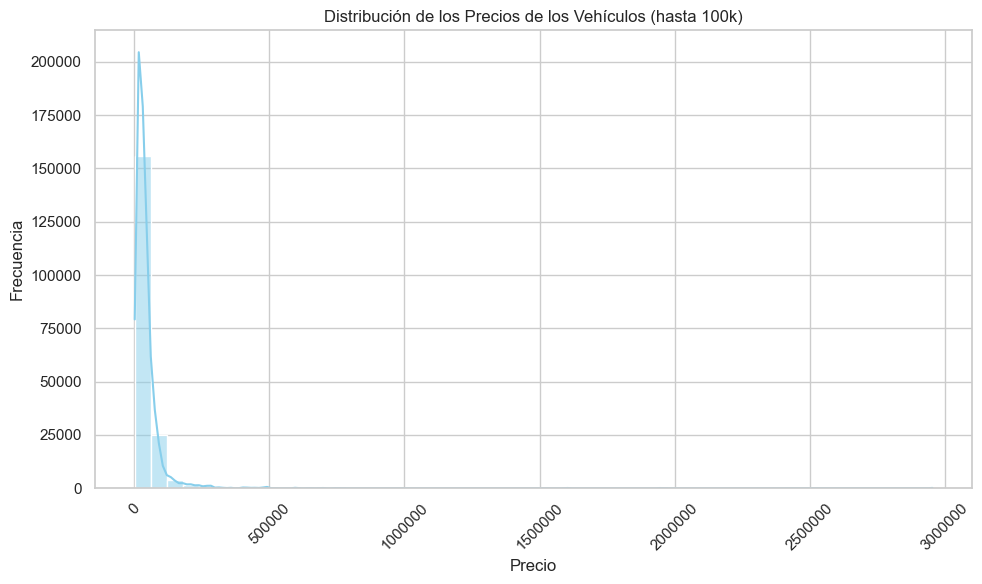

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_car_price['price'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de los Precios de los Vehículos (hasta 100k)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Quitar notación científica y limitar el eje X
plt.ticklabel_format(axis='x', style='plain')
#plt.xlim(0, 100000)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Mapa de calor de correlaciones

En este análisis, generamos un mapa de calor para visualizar las correlaciones entre las variables numéricas del dataset.

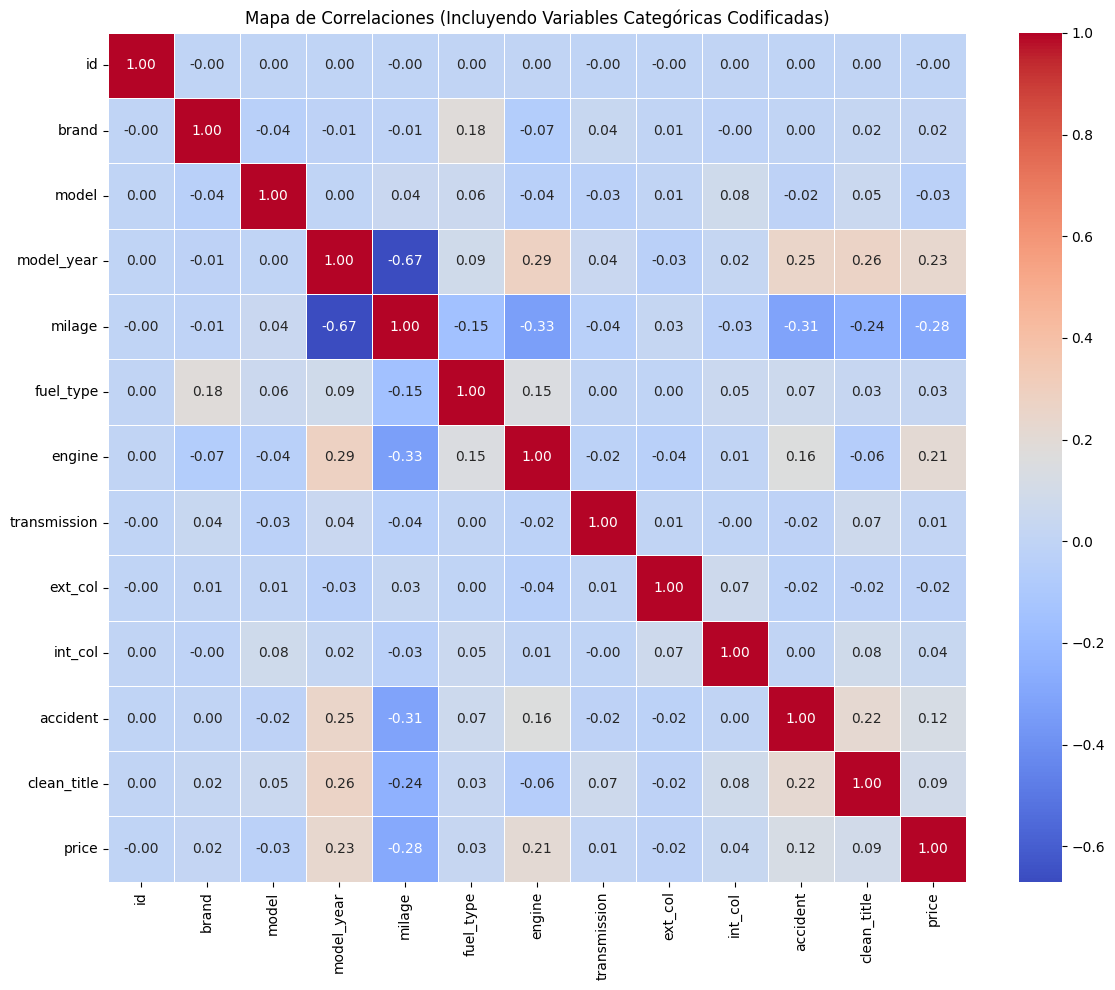

In [6]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar el DataFrame original para no modificarlo directamente
df_encoded = df_car_price.copy()

# Codificar las columnas categóricas con LabelEncoder
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlaciones (Incluyendo Variables Categóricas Codificadas)')
plt.tight_layout()
plt.show()


### Relación entre variables numéricas

En este análisis, generamos un gráfico de pares para visualizar la relación entre todas las variables numéricas del dataset. Este gráfico nos permite identificar patrones, tendencias y posibles correlaciones entre las variables.

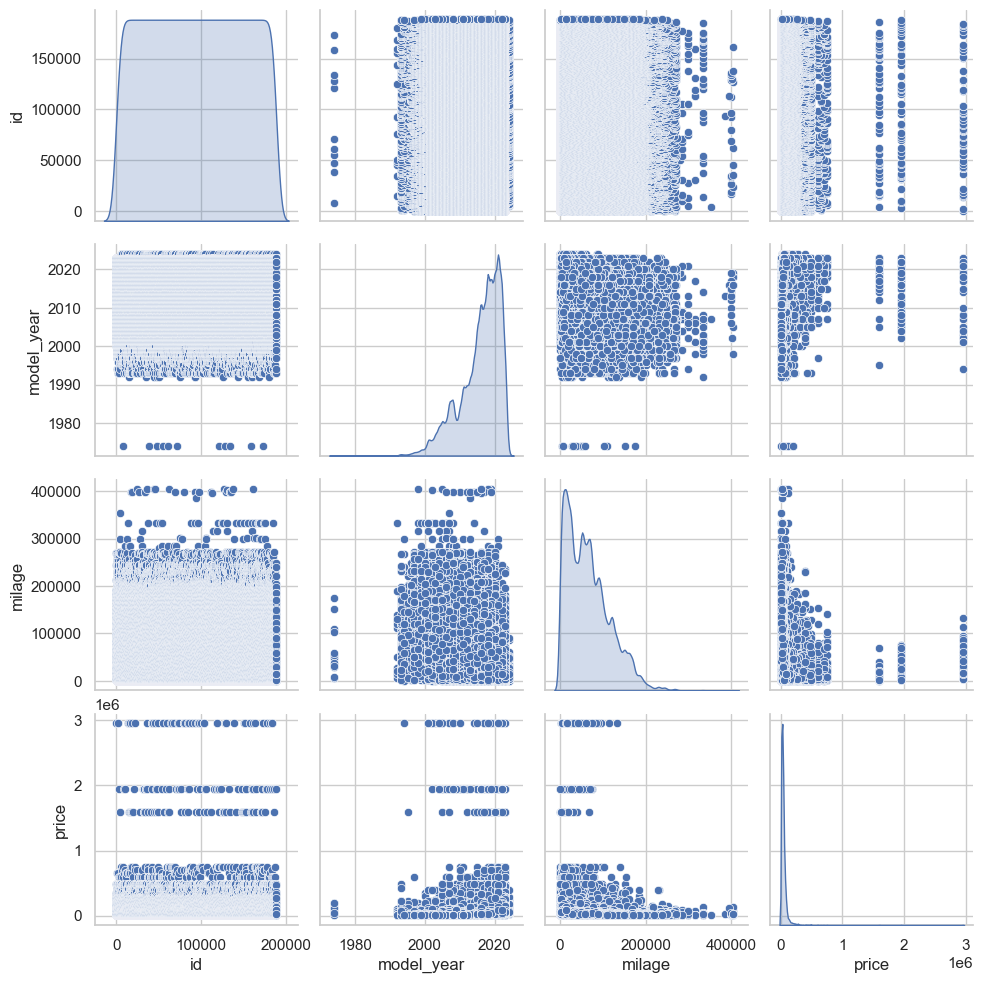

<Figure size 1000x800 with 0 Axes>

In [31]:
sns.pairplot(df_car_price, diag_kind='kde')
plt.figure(figsize=(10, 8))
plt.suptitle('Relación entre Variables Numéricas', y=1.02)
plt.show()

### Tendencia

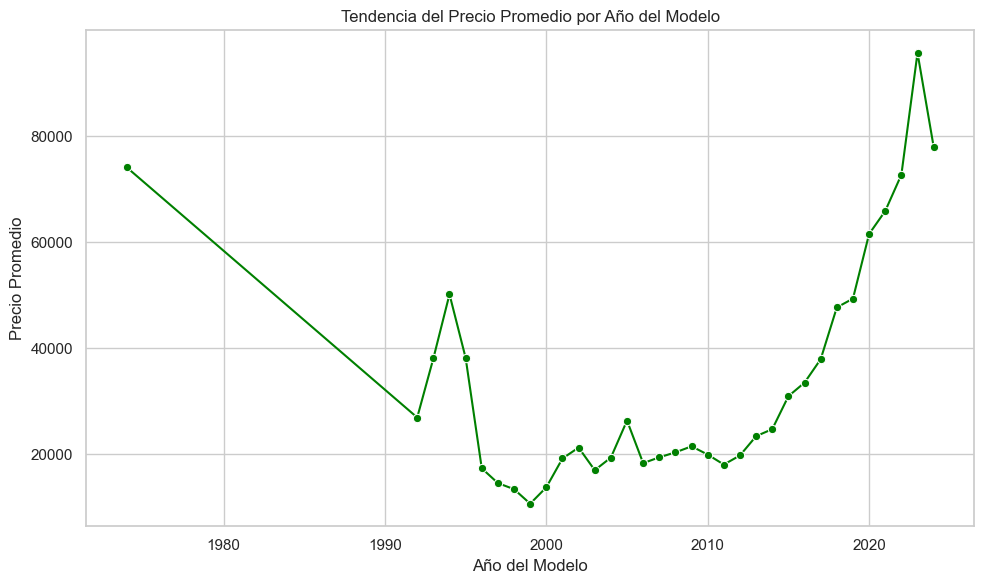

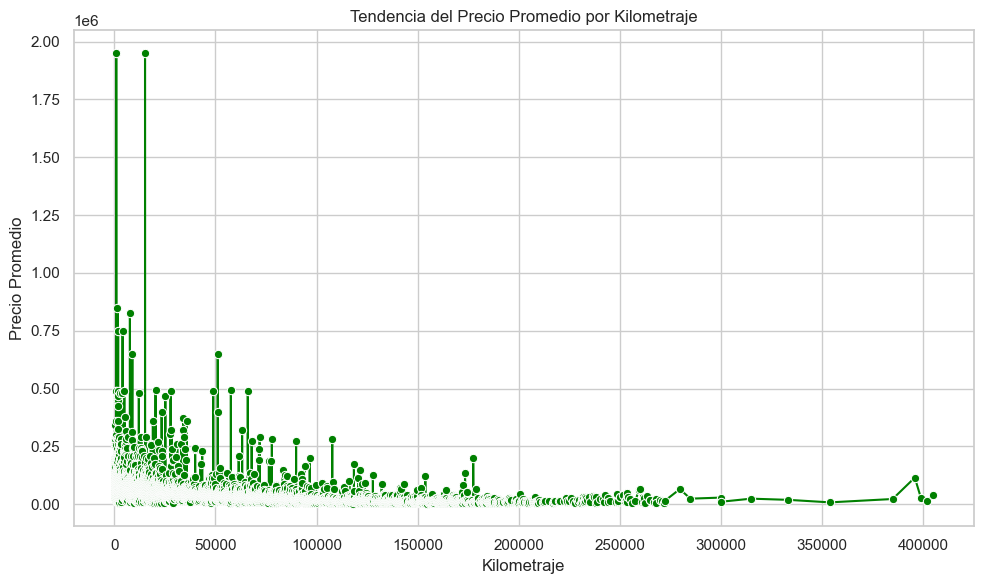

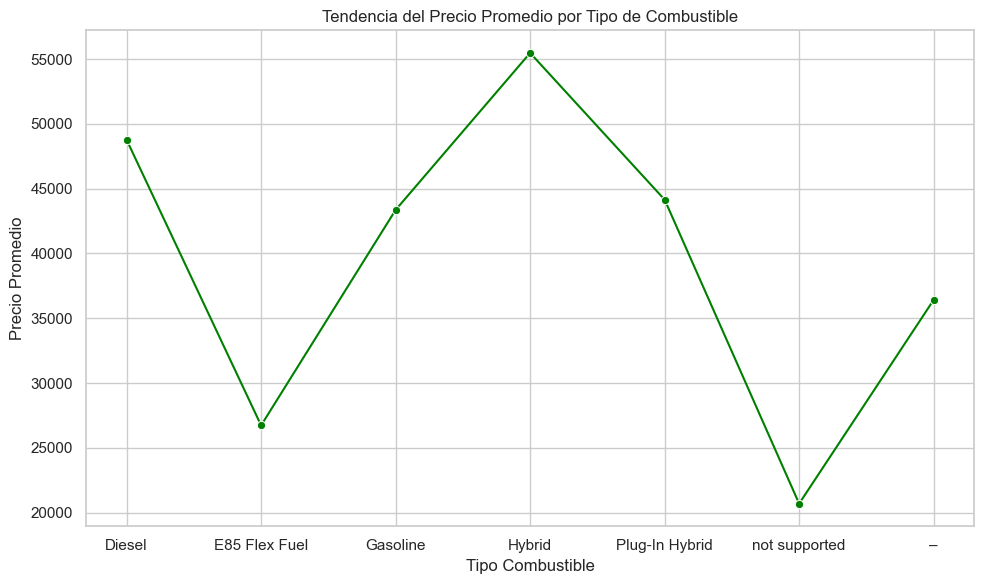

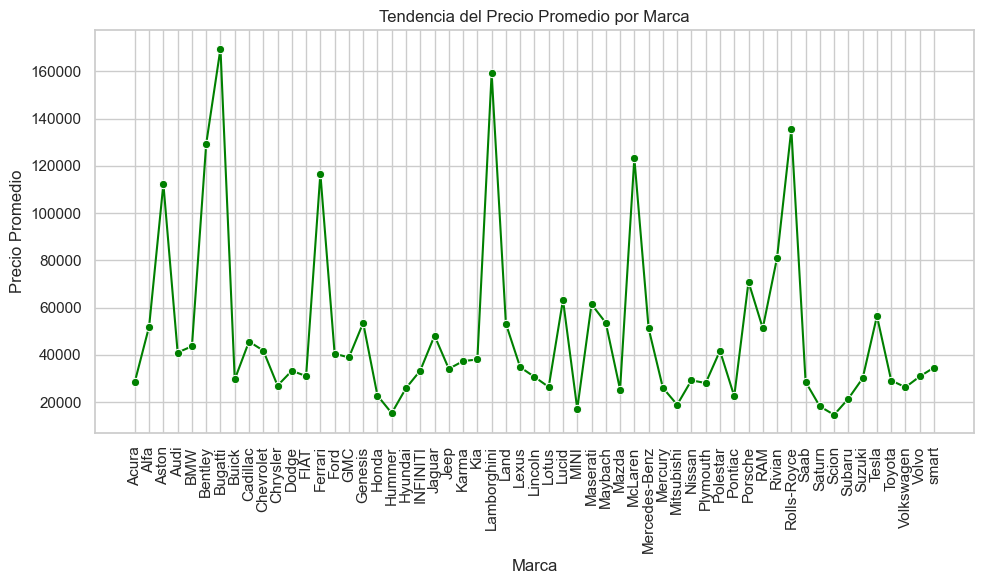

In [43]:
# Calcular precio promedio por año del modelo
avg_price_by_year = df_car_price.groupby('model_year')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_year, x='model_year', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Año del Modelo')
plt.xlabel('Año del Modelo')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular precio promedio por media de kilometraje
avg_price_by_milage = df_car_price.groupby('milage')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_milage, x='milage', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular precio promedio por motor
avg_price_by_fuel_type = df_car_price.groupby('fuel_type')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_fuel_type, x='fuel_type', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Tipo de Combustible')
plt.xlabel('Tipo Combustible')
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular precio promedio por motor
avg_price_by_brand = df_car_price.groupby('brand')['price'].mean().reset_index()

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_brand, x='brand', y='price', marker='o', color='green')
plt.title('Tendencia del Precio Promedio por Marca')
plt.xlabel('Marca')
plt.xticks(rotation=90)
plt.ylabel('Precio Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

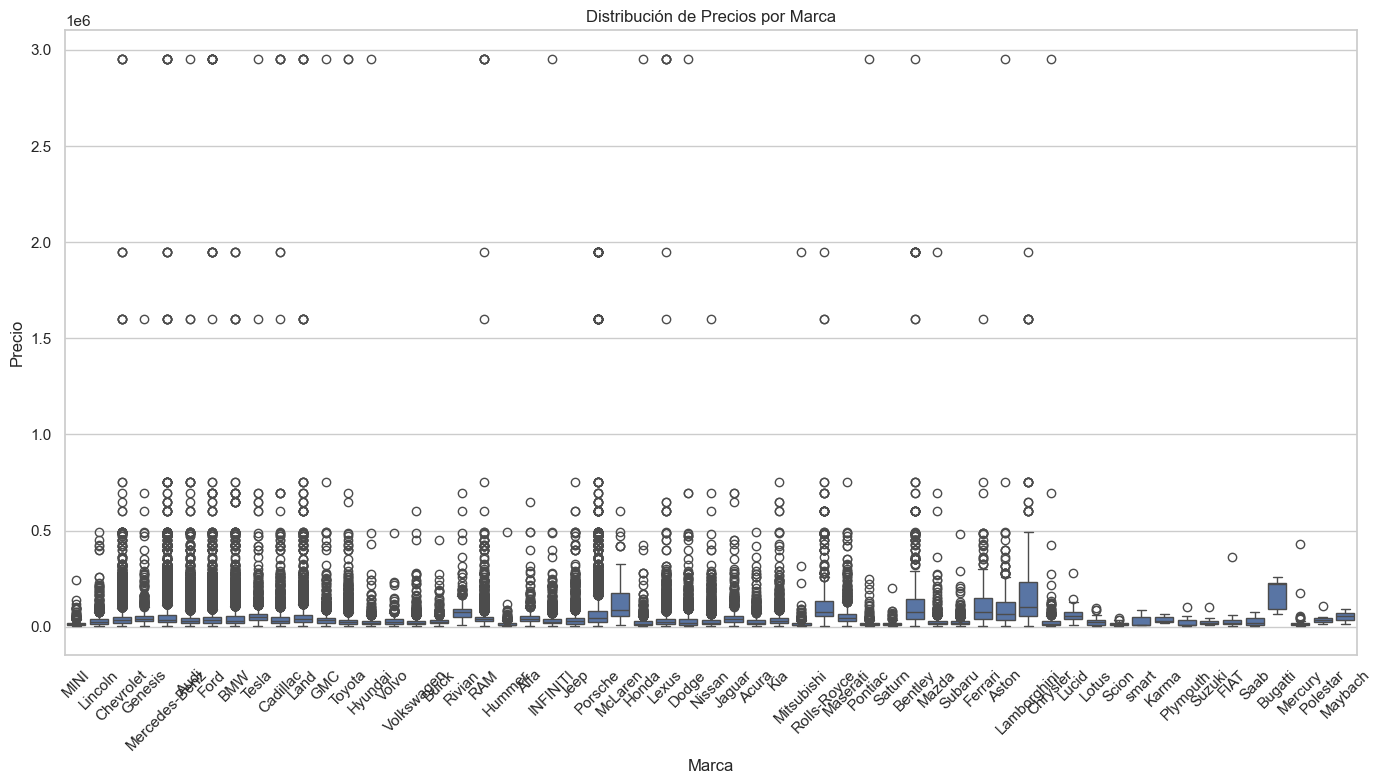

In [44]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_car_price, x='brand', y='price')
plt.title('Distribución de Precios por Marca')
plt.xlabel('Marca')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import scipy.stats as stats

# Crear listas de precios por marca
grouped_prices = [group['price'].values for name, group in df_car_price.groupby('brand')]
# Crear listas de precios por marca
grouped_prices = [group['price'].values for name, group in df_car_price.groupby('brand')]
# Aplicar ANOVA de una vía
f_statistic, p_value = stats.f_oneway(*grouped_prices)

print(f"F-statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.4f}")


F-statistic: 160.90
P-value: 0.0000


p < 0.05, puedes rechazar la hipótesis nula: hay diferencias significativas entre los precios medios de al menos algunas marcas.

Test HSD de Tukey: Test de comparaciones múltiples que permite comparar las medias de los niveles de un factor después de haber rechazado la Hipótesis nula de igualdad de medias mediante la técnica ANOVA

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
    group1        group2      meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------
        Acura          Alfa   23364.5988    0.0    9744.3083   36984.8893   True
        Acura         Aston   83736.0917    0.0   62476.6797  104995.5038   True
        Acura          Audi   12376.3605    0.0    5190.7819   19561.9391   True
        Acura           BMW    15031.279    0.0    8073.8501   21988.7078   True
        Acura       Bentley  100644.4368    0.0   89374.0653  111914.8083   True
        Acura       Bugatti  140971.5035 0.0018   22827.0511  259115.9559   True
        Acura         Buick     989.3386    1.0  -11106.5645   13085.2417  False
        Acura      Cadillac   17030.5983    0.0    9060.2942   25000.9024   True
        Acura     Chevrolet   13208.2586    0.0    6233.4108   20183.1065   True
        Acura      Chrysler 

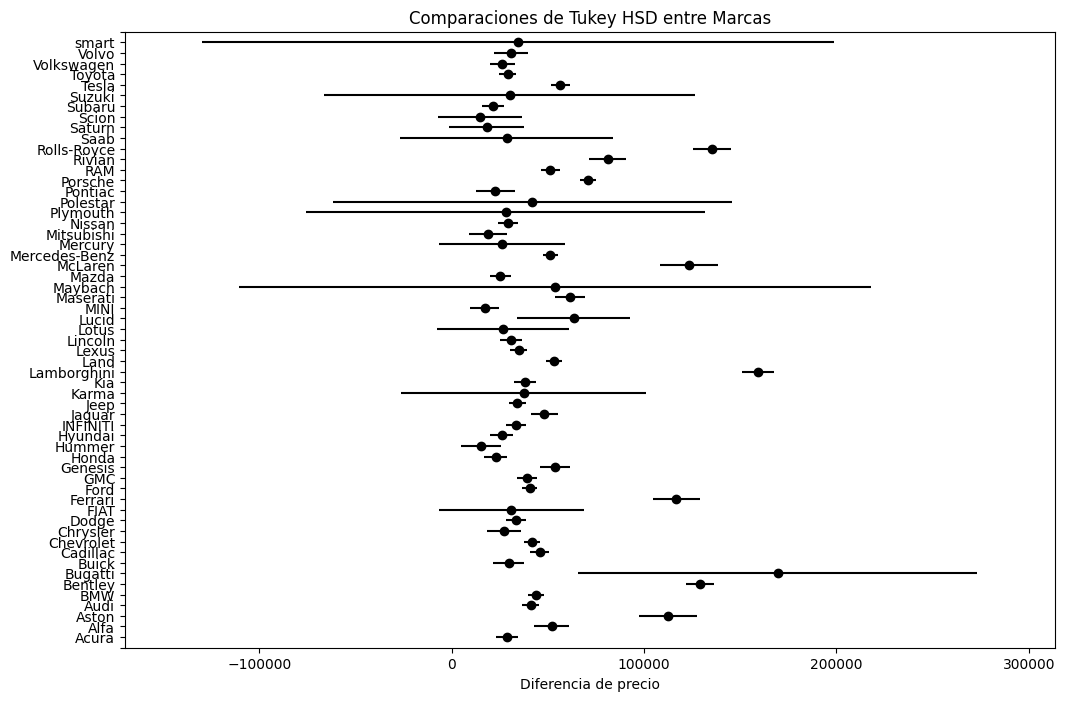

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Asegurar que 'brand' sea tipo categoría
df_car_price['brand'] = df_car_price['brand'].astype(str)

# Aplicar el test de Tukey
tukey = pairwise_tukeyhsd(endog=df_car_price['price'],     # Variable dependiente
                          groups=df_car_price['brand'],    # Grupos por los que se comparan
                          alpha=0.05)

# Mostrar el resumen
print(tukey)

tukey.plot_simultaneous(figsize=(12, 8))
plt.title('Comparaciones de Tukey HSD entre Marcas')
plt.xlabel('Diferencia de precio')
plt.show()


### Relación

### Definición de la variable objetivo

Para este análisis, hemos decidido que la variable objetivo será

#### Justificación:
1. Es una variable

#### Tratamiento de la variable objetivo:
- Verificamos si hay valores faltantes en

# 5 Análisis estadístico

 ## Pruebas paramétricas
 ###   pruebas de normalidad

###   Kolmogorov-Simirnov

Hallazgos: 

 ### Shapiro-Wilk

Hallazgos: 

#### Visualización de la distribución: Gráfico Q-Q

### Prueba de Homegeneidad de varianza

Nos hemos decantado por Levene porque la prueba de Bartlett es más sensible a desviaciones de normalidad en los datos.

#### Levene

#### Generamos un boxplot para comparar visualmente las distribuciones de Diabetes_Prevalence entre los países

#### Prueba de ANOVA:
La prueba de ANOVA permitirá evaluar si las medias de diabetes_prevalence son significativamente diferentes entre los países

## 6. Análisis Univariante
### 6.1 Estadísticas Descriptivas
- Presentamos las estadísticas descriptivas básicas para entender las características generales de las variables numéricas en el dataset.

#### 6.2 Visualización de la Distribución


Hallazgos: 

### Conclusión: